In [1]:
import pandas as pd

In [2]:
# Read the data xlsx
df_20_a = pd.read_csv('data/stop_level/stop2020_1to6.csv')
df_20_b = pd.read_csv('data/stop_level/stop2020_7to11.csv')
df_20_c = pd.read_csv('data/stop_level/stop2020_11to2021_1.csv')
df_21_a = pd.read_csv('data/stop_level/stop2021_2to2021_4.csv')
df_21_b = pd.read_csv('data/stop_level/stop2021_5to2021_7.csv')
df_21_c = pd.read_csv('data/stop_level/stop2021_8to2021_10.csv')
df_21_d = pd.read_csv('data/stop_level/stop2021_11to2021_12.csv')
df_22_a = pd.read_csv('data/stop_level/stop2022_1to2022_2.csv')
df_22_b = pd.read_csv('data/stop_level/stop2022_3to2022_5.csv')
df_22_c = pd.read_csv('data/stop_level/stop2022_6to2022_8.csv')
df_22_d = pd.read_csv('data/stop_level/stop2022_7to2022_9.csv')
df_22_d = df_22_d[df_22_d['OPD_DATE'] >= '2022-09-01']
df_22_e = pd.read_csv('data/stop_level/stop2022_10to2022_12.csv')

In [3]:
# Vertically concatenate the dataframes, drop the index column
df = pd.concat([df_20_a, df_20_b, df_20_c, df_21_a, df_21_b, df_21_c, df_21_d, df_22_a, df_22_b, df_22_c, df_22_d, df_22_e], axis=0).reset_index(drop=True)
# drop first two columns
df = df.drop(df.columns[[0, 1]], axis=1)
# convert 'datenew' column to datetime
df['datenew'] = pd.to_datetime(df['datenew'], format='%Y-%m-%d')
# aggregate 'TOTAL_BOARDING' by date column on a weekly basis, per STOP_ID
df_weekly = df.groupby(['STOP_ID', pd.Grouper(key='datenew', freq='W-MON')])['TOTAL_BOARDING'].sum().reset_index()

In [6]:
baseline_date = pd.to_datetime('2022-01-01')
df_weekly_baseline = df_weekly[df_weekly['datenew'] > baseline_date]
# find weekly change in total_boarding per stop compared to baseline week
df_weekly_baseline['weekly_change'] = df_weekly_baseline.groupby('STOP_ID')['TOTAL_BOARDING'].diff()

df_weekly_baseline

C:\Users\ekino\AppData\Local\Temp\ipykernel_19104\4127222583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly_baseline['weekly_change'] = df_weekly_baseline.groupby('STOP_ID')['TOTAL_BOARDING'].diff()


,STOP_ID,datenew,TOTAL_BOARDING,weekly_change
101,250,2022-01-03,13,NaN
102,250,2022-01-10,69,56.0
103,250,2022-01-17,50,-19.0
104,250,2022-01-24,85,35.0
105,250,2022-01-31,99,14.0
...,...,...,...,...
939129,99830,2022-11-21,0,0.0
939130,99830,2022-11-28,0,0.0
939131,99830,2022-12-05,0,0.0
939132,99830,2022-12-12,0,0.0


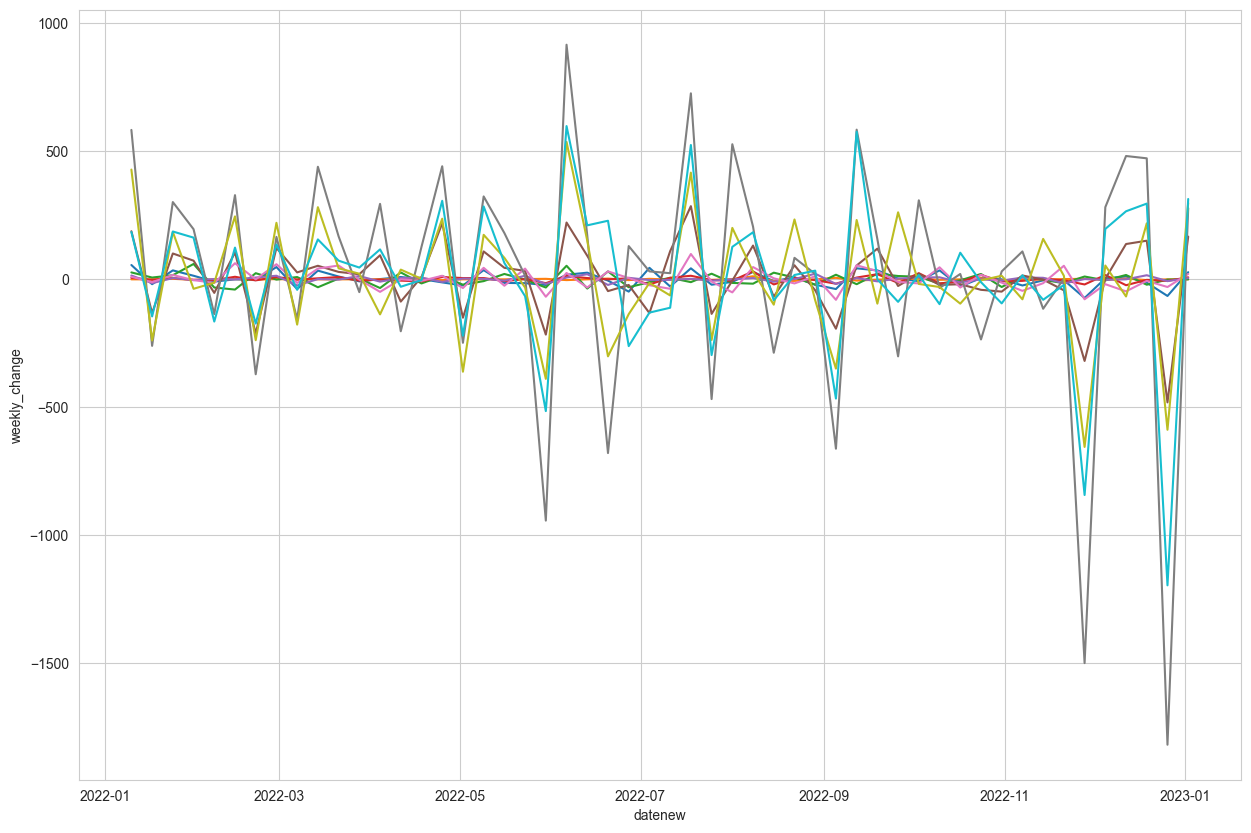

In [11]:
# Plot the weekly_change for the first 50 stop IDs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

all_stop_IDs = df_weekly_baseline['STOP_ID'].unique()
for i in all_stop_IDs[0:10]:
    sns.lineplot(x='datenew', y='weekly_change', data=df_weekly_baseline[df_weekly_baseline['STOP_ID'] == i])
plt.show()

In [3]:
# Read census data
df_census = pd.read_excel('data/stop_level/stops_census_info.xlsx')

# Check df_census for number of duplicates
print(df_census.duplicated().sum())

# Drop duplicates
df_census = df_census.drop_duplicates()

29298


In [5]:
# Merge based on 'STOP_ID'
df_merged = pd.merge(df, df_census, on='STOP_ID')

df_merged = df_merged[['OPD_DATE', 'STOP_ID', 'TOTAL_BOARDING', 'TOTAL_ALIGHTING', 'weekday', 'month', 'geometry', 'NAME', 'GEOID']]

df_merged.head()

,OPD_DATE,STOP_ID,TOTAL_BOARDING,TOTAL_ALIGHTING,weekday,month,geometry,NAME,GEOID
0,2020-01-01,258,1,0,Wednesday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
1,2020-01-02,258,17,2,Thursday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
2,2020-01-03,258,17,0,Friday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
3,2020-01-04,258,0,0,Saturday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
4,2020-01-05,258,0,0,Sunday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002


In [9]:
# See the number of unique GEOIDs
print(df_merged['GEOID'].nunique())

# Create new GEOID column that spans from 1 to 457
df_merged['GEOID_cat'] = df_merged['GEOID'].astype('category')

df_merged['GEOID_cat']

457


0          53033008002
1          53033008002
2          53033008002
3          53033008002
4          53033008002
              ...     
1055993    53033009900
1055994    53033009900
1055995    53033009900
1055996    53033009900
1055997    53033009900
Name: GEOID_cat, Length: 1055998, dtype: category
Categories (457, int64): [53033000101, 53033000102, 53033000201, 53033000202, ..., 53061051100, 53061051302, 53061051916, 53061051938]

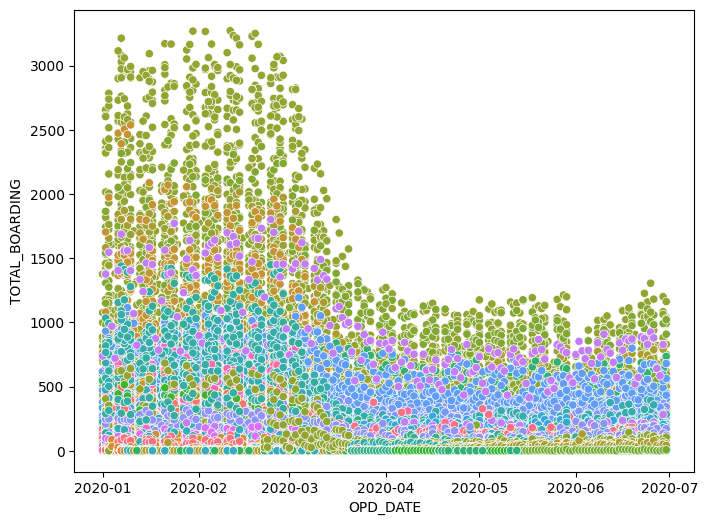

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Groupby GEOID, scatter plot boardings over time for each census tract on the same plot
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='OPD_DATE', y='TOTAL_BOARDING', hue='GEOID_cat', data=df_merged, legend=False, ax=ax)
plt.show()